# Washington D.C. Bike share Predic Model

● Using a complete 2011 - 2012 dataset (kaggle_sample.csv)<br>
● The 'count' column of test.csv has already been predicted using XGBoost Model

# Data Processing

### Load Data

In [18]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#to display all the graph
%matplotlib inline
sns.set_style("whitegrid",{'grid.linestyle': '--'})

import warnings
warnings.filterwarnings("ignore")

In [19]:
df = pd.read_csv("kaggle_sample.csv", parse_dates = ["date", "time"])
df.shape

(17379, 11)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        17379 non-null  datetime64[ns]
 1   time        17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   holiday     17379 non-null  int64         
 4   workingday  17379 non-null  int64         
 5   weather     17379 non-null  int64         
 6   temp        17379 non-null  float64       
 7   atemp       17379 non-null  float64       
 8   humidity    17379 non-null  int64         
 9   windspeed   17379 non-null  float64       
 10  count       17379 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(5)
memory usage: 1.5 MB


### Checking missing values

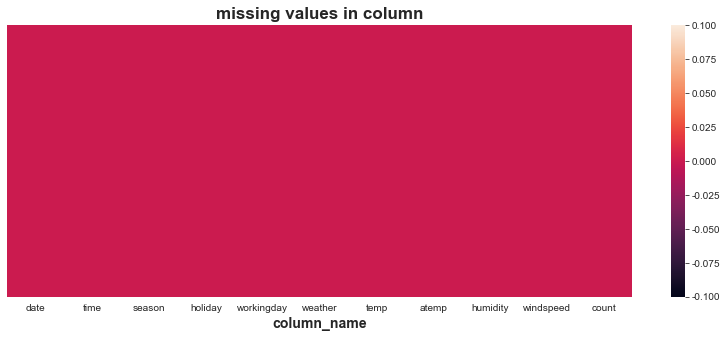

In [21]:
plt.figure(figsize=(14, 5))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False)
plt.xlabel("column_name", size=14, weight="bold")
plt.title("missing values in column",fontweight="bold",size=17)
plt.show()

Missing values not present

In [22]:
df.head()

,date,time,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01,2022-07-29 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16.0
1,2011-01-01,2022-07-29 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40.0
2,2011-01-01,2022-07-29 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32.0
3,2011-01-01,2022-07-29 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13.0
4,2011-01-01,2022-07-29 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1.0


### Split data, time column

In [23]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["dayofweek"] = df["date"].dt.dayofweek

df["hour"] = df["time"].dt.hour

In [24]:
df = df.drop(columns=['date', 'time'], axis = 1)

In [25]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,dayofweek,hour
0,1,0,0,1,9.84,14.395,81,0.0,16.0,2011,1,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,40.0,2011,1,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,32.0,2011,1,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,13.0,2011,1,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,1.0,2011,1,1,5,4


1. <br>
'holiday' feature should be removed<br>
January 1st is a day off.<br>
But, this table shows 0 value in the holiday col.<br>
Of course it was 0 value in the workingday col.

I think the holiday column only indicates whether it is a regular weekend<br>
except public holiday including substitute holiday.

Therefore, the workingday column is judged to be more accurate data<br>
than the holiday column showing only weekend.


2. <br>
dayofweek explanation<br>
0 = mon<br>
1 = tue<br>
2 = wed<br>
3 = thu<br>
4 = fri<br>
5 = sat<br>
6 = sun

# EDA

### HeatMap
Check the correlation between variables

<AxesSubplot:>

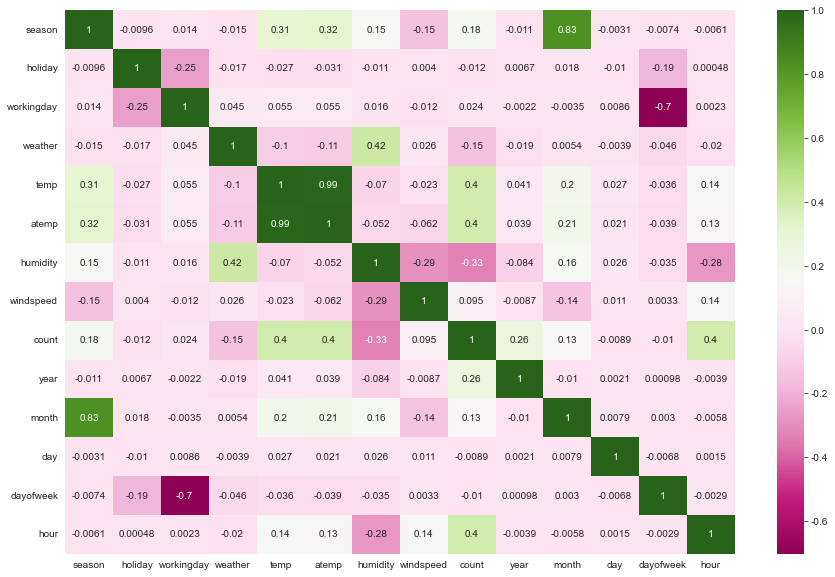

In [26]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),cmap='PiYG',annot=True)

##### Multicollinearity
1. temp & atemp<br>
'temp & atemp' are highly correlated.<br>
Since temp is more objective data than atemp, <br>
so atemp will be removed.<br>


2. season & month
'season & month' are also highly correlated.<br>
'season' column is easier to see than month,<br>
so month will be removed.

#### Correlation between dependent and independent variables
These independent variables are highly correlated with 'count'<br>
1. temp & atemp<br>
2. year<br>
3. hour

### Feature Categorization

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   holiday     17379 non-null  int64  
 2   workingday  17379 non-null  int64  
 3   weather     17379 non-null  int64  
 4   temp        17379 non-null  float64
 5   atemp       17379 non-null  float64
 6   humidity    17379 non-null  int64  
 7   windspeed   17379 non-null  float64
 8   count       17379 non-null  float64
 9   year        17379 non-null  int64  
 10  month       17379 non-null  int64  
 11  day         17379 non-null  int64  
 12  dayofweek   17379 non-null  int64  
 13  hour        17379 non-null  int64  
dtypes: float64(4), int64(10)
memory usage: 1.9 MB


'season', 'holiday', 'workingday', 'weather', <br>
'year', 'month', 'day', 'weekend', 'hour' <br>
<b>The above data are categorical types.<b>

So, the data of int64 should be changed to category type.

### Check the VIF value

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
 
   # Calculating VIF
   vif = pd.DataFrame()
   vif["variables"] = X.columns
   vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
 
   return(vif)

In [29]:
# Excpet dependent varaubale

calc_vif(df[[i for i in df.describe().columns 
                if i not in ['count'] ]])

,variables,VIF
0,season,21.386386
1,holiday,1.543265
2,workingday,8.976866
3,weather,7.639762
4,temp,335.879862
5,atemp,381.761436
6,humidity,17.518428
7,windspeed,4.090190
8,year,64.960019
9,month,15.161339


Remove 'atemp', 'month', 'holiday' column<br>

In [30]:
calc_vif(df[[i for i in df.describe().columns 
                if i not in ['count', 'atemp', 'month', 'holiday'] ]])

,variables,VIF
0,season,7.092216
1,workingday,6.241530
2,weather,7.622385
3,temp,8.825919
4,humidity,17.389835
5,windspeed,3.889881
6,year,51.446222
7,day,4.194912
8,dayofweek,6.451194
9,hour,4.238645


'humidity' and 'weather' are correlated by looking at the heatmap,<br>
but these two variables are irreplaceable.

'year' should not be deleted<br>
because it tells us that the demand for bicycle rental is<br>
increasing every year.

So, I will not delete these coulmns.

### Barplot

'year, month, day, hour & count' Visualization

[Text(0.5, 0, 'Hour'), Text(0.5, 1.0, 'Hourly rental volumn')]

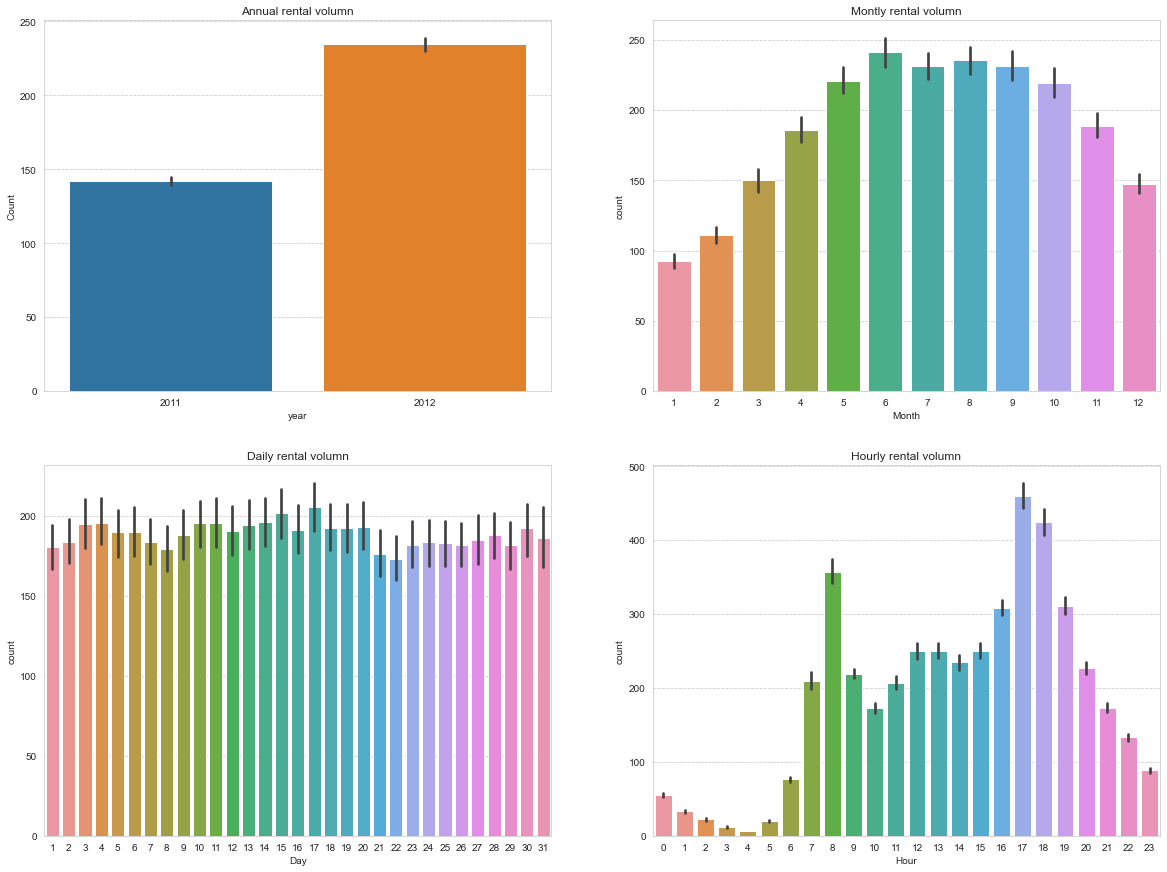

In [31]:
figure, ((ax1, ax2), (ax3, ax4))  = plt.subplots(nrows = 2, ncols = 2)
figure.set_size_inches(20, 15)

sns.barplot(data = df, x = "year", y = "count", ax = ax1)
sns.barplot(data = df, x = "month", y = "count", ax = ax2)
sns.barplot(data = df, x = "day", y = "count", ax = ax3)
sns.barplot(data = df, x = "hour", y = "count", ax = ax4)

ax1.set(ylabel = 'Count', title = "Annual rental volumn")
ax2.set(xlabel = 'Month', title = "Montly rental volumn")
ax3.set(xlabel = 'Day', title = "Daily rental volumn")
ax4.set(xlabel='Hour', title = "Hourly rental volumn")

##### Annual rental volumn
Compared to the previous year, <br>
the count is gradually increasing.

##### Monthly rental volumn
Large count : June ~ October<br>
Low count : December ~ March
    
The largest rental volume : June, September<br>
The smallest rental volume : January, Feburary
    
##### Daily rental volumn
There is not much difference by day, and<br>
no noticeable event at the beginning fo the month or<br>
at the end of the month.

##### hourly rental volumn
Large count : 7 a.m. ~ 8 p.m.<br>
Especially high count : rush hour (7 ~ 9AM, 5 ~ 7PM)

Low count : Early morning hours (12 ~ 6AM)

### Boxplot

'season, holiday, workingday, weather & count' Visualization

[Text(0.5, 0, 'Weather'), Text(0.5, 1.0, 'Weather rental volumn')]

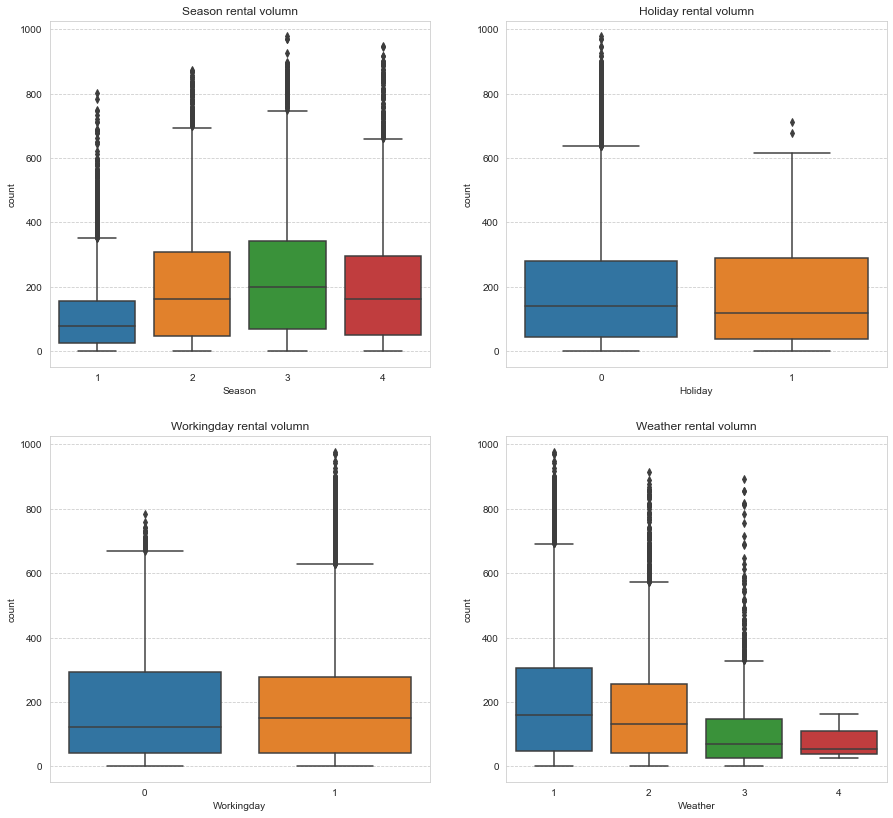

In [15]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(15, 14)

sns.boxplot(data = df, y = "count", x = "season", orient = "v", ax = axes[0][0])
sns.boxplot(data = df, y = "count", x = "holiday", orient = "v", ax = axes[0][1])
sns.boxplot(data = df, y = "count", x = "workingday", orient = "v", ax = axes[1][0])
sns.boxplot(data = df, y = "count", x = "weather", orient = "v", ax = axes[1][1])

axes[0][0].set(xlabel = 'Season', title = "Season rental volumn")
axes[0][1].set(xlabel = 'Holiday', title = "Holiday rental volumn")
axes[1][0].set(xlabel = 'Workingday', title = "Workingday rental volumn")
axes[1][1].set(xlabel = 'Weather', title = "Weather rental volumn")

##### Season rental volumn
1 (spring), 2 (summer), 3 (autumn), 4 (winter)<br>
summer, autumn > spring, winter

##### Holiday rental volumn & Workingday rental volumn
By a narrow margin, holiday > workingday

##### Weather rental volumn
1 (clean), 2 (cloudy), 3 (light snow&rain), 4 (heavy snow&rain)<br>
count : 1 > 2 > 3 > 4

Those who rented bicycles in heavy snow and rainy weather may be people<br>
with urgent circumstances.<br>
They are really a few.<br>
So this is unusual, and it needs to be removed.

∴ Overall, there seems to be a lot of outliers.<br>
&nbsp;&nbsp;&nbsp;&nbsp;We need to get rid of outliers.

### Pointplot

'hour, workingday, dayofweek, weather, season & count' Visualization

In [16]:
categorical_feature = ["season", "holiday", "workingday", "weather",
                            "year", "month", "day", "dayofweek", "hour"]

for var in categorical_feature :
    df[var] = df[var].astype("category")

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      17379 non-null  category
 1   holiday     17379 non-null  category
 2   workingday  17379 non-null  category
 3   weather     17379 non-null  category
 4   temp        17379 non-null  float64 
 5   atemp       17379 non-null  float64 
 6   humidity    17379 non-null  int64   
 7   windspeed   17379 non-null  float64 
 8   count       17379 non-null  float64 
 9   year        17379 non-null  category
 10  month       17379 non-null  category
 11  day         17379 non-null  category
 12  dayofweek   17379 non-null  category
 13  hour        17379 non-null  category
dtypes: category(9), float64(4), int64(1)
memory usage: 835.3 KB
